In [1]:
import math
import os
import re
import shutil
import sys
import warnings

import chardet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from constants import bins_axis_names, bin_dimensions_regex, boat_speed_feature, \
                    boxplot_axis_name, feature_regex, identifier_features, \
                    fiber_optics_structure_features, fiber_optics_appendix_features, \
                    other_sensor_features, wind_features

In [2]:
def read_csv(fnames):
    """Read CSV file(s) to a Pandas Dataframe"""
    def detect_and_read(fname):
        with open(fname, 'rb') as f:
            return pd.read_csv(fname, sep=';', encoding=chardet.detect(f.read())['encoding'])
    return pd.concat(map(lambda fname: detect_and_read(fname), fnames), sort=False)

def preprocess_data(df, identifier_cols, cols_to_preprocess, other_cols, regex):
    """Preprocess the dataset"""
    preprocessed_df = pd.DataFrame()
    for old_col, new_col in identifier_cols + cols_to_preprocess + other_cols:
        if (old_col, new_col) not in identifier_cols + other_cols:
            preprocessed_df[new_col] = df.filter(regex=(regex.format(old_col))).mean(axis=1)
        else:
            preprocessed_df[new_col] = df[old_col]
    return preprocessed_df

def compute_corr(df, target_feature, num_features=50):
    """Compute top correlated features with the target feature"""
    corrs = {}
    for col in df.columns:
        if col != target_feature:
            corr = df[target_feature].corr(df[col])
            if not math.isnan(corr):
                corrs[col] = corr
    sorted_corrs = sorted(corrs.items(), key=lambda x: abs(x[1]), reverse=True)[:num_features]
    sorted_corrs = sorted(sorted_corrs, key=lambda x: x[1], reverse=True)
    cols = [target_feature] + [x[0] for x in sorted_corrs]
    if len(cols) <= 1:
        return None
    return df[cols].corr()

def create_bins(df, wind_features, target_feature, dx=5, dy=2, min_thresh=5, exclude=[]):
    """Create bins"""
    bins = {}
    for max_x in range(-180, 180, dx):
        for max_y in range(0, math.ceil(df[wind_features[1]].max()), dy):
            binned_df = df.query('{0} >= {2} and {0} < {2}+{4} and {1} >= {3} and {1} < {3}+{5}'.format(wind_features[0], wind_features[1], max_x, max_y, dx, dy))
            bin_size = len(binned_df.index)
            bin_corr = compute_corr(binned_df.drop([x[1] for x in exclude], axis=1), target_feature)
            if bin_size >= min_thresh and bin_corr is not None:
                bin_name = 'bin_x{}to{}_y{}to{}'.format(max_x, max_x+dx, max_y, max_y+dy)
                bins[bin_name] = {'bin': binned_df, 'size': bin_size, 'corr': bin_corr}
    return bins, dx, dy, max_x, max_y

def plot_wind_angle_speed(df, wind_features, axis_names, x_start, y_start, x_finish, y_finish, dx, dy, markersize, main=False):
    """Plot the wind angle-speed space"""
    _, ax = plt.subplots()
    ax.set_xlabel(axis_names[0])
    ax.set_ylabel(axis_names[1])
    ax.plot(df[wind_features[0]].tolist(), df[wind_features[1]].tolist(), 'ko', markersize=markersize)
    if main:
        ax.set_xticks(np.arange(x_start, x_finish, dx*6))
        ax.set_xticks(np.arange(x_start, x_finish, dx), minor=True)
        ax.set_yticks(np.arange(y_start, y_finish, dy))
        ax.grid(which='both', lw=.75)
    else:
        ax.set_xlim(x_start, x_finish)
        ax.set_ylim(y_start, y_finish)
        ax.grid(lw=.75)
    plt.tight_layout()
    plt.show()
    plt.clf()

def plot_boxplot(df, target_feature, axis_name):
    """Plot the boxplot for boat speed"""
    ax = df.boxplot(column=target_feature, showfliers=df[target_feature].median() == df[target_feature].mode().iloc[0], return_type='axes')
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.set_ylabel(axis_name)
    plt.tight_layout()
    plt.show()
    plt.clf()

def plot_corr(df, corr):
    """Plot the correlations with boat speed"""
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
    plt.xticks(rotation=30, ha='right', fontsize=3)
    plt.yticks(fontsize=3)
    plt.tight_layout()
    plt.show()
    plt.clf()

In [3]:
# Ignore RunTimeWarning.
warnings.filterwarnings('ignore')

# Ignore PyPlot warning.
plt.rcParams.update({'figure.max_open_warning': 0})

# Version number.
version = 'v2'

In [4]:
# Read from CSV file(s).
df = read_csv(map(lambda fname: './data/{}/{}.csv'.format(version, fname), ['data-part-1', 'data-part-2']))

# Show examples of the data.
df.head()

,Date,Hour,IxBlue_Heading,IxBlue_Heave,IxBlue_HeaveAccel,IxBlue_Pitch,IxBlue_PitchRate,IxBlue_Roll,IxBlue_RollRate,IxBlue_SurgeAccel,...,VarFilter_WTP_gyro_trm,VarFilter_WTP_pitch_rate,VarFilter_WTP_yaw_rate,VarFilter_sirius_b2_ 1,VarFilter_sirius_b2_ 2,VarFilter_sirius_b2_ 3,VarFilter_sirius_b2_ 4,VarFilter_sirius_b3_11,VarFilter_sirius_b3_12,Unnamed: 176
0,07/06/2018,15:00:00,197.09399,0.03528,0.06,-0.104,0.04667,-1.180,-0.03500,-0.02,...,359.99982,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
1,07/06/2018,15:00:01,197.04001,0.03732,-0.10,-0.137,0.06333,-1.177,-0.08917,-0.04,...,359.98517,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
2,07/06/2018,15:00:02,196.94600,0.02032,-0.02,-0.087,0.33250,-1.326,-0.19500,0.08,...,359.99731,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
3,07/06/2018,15:00:03,196.85600,0.01018,0.02,0.001,-0.12083,-1.281,0.11667,-0.10,...,359.96817,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
4,07/06/2018,15:00:04,196.71500,0.00568,0.01,-0.261,-0.12583,-1.164,-0.01750,0.09,...,359.96942,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN


In [5]:
# Preprocess the dataset.
df = preprocess_data(df,
                    identifier_features,
                    fiber_optics_structure_features + fiber_optics_appendix_features,
                    other_sensor_features + wind_features + [boat_speed_feature],
                    feature_regex)

# Show examples of the preprocessed data.
df.head()

,Date,Hour,Latitude,Longitude,Max_Front_Beam_Temp_Port,Max_Front_Beam_Temp_To_Port,Max_Front_Beam_To_Port,Max_Front_Beam_Lower_Aft_Rake_Port,Max_Front_Beam_Lower_Forward_Rake_Port,Max_Front_Beam_Upper_Aft_Rake_Port,...,Rudder_Outside_Load_Port,Rudder_Angle_Starboard,Rudder_Elevator_Angle_Starboard,Rudder_Inside_Load_Starboard,Rudder_Outside_Load_Starboard,Shroud_Load_Port,Shroud_Load_Starboard,Wind_Angle,Wind_Speed,Boat_Speed
0,07/06/2018,15:00:00,47.70608,-3.36854,NaN,NaN,NaN,NaN,NaN,NaN,...,6.48607,-2.90385,2.70919,-0.33398,-14.44734,0.40253,0.58144,10.49710,8.16012,7.15217
1,07/06/2018,15:00:01,47.70605,-3.36855,NaN,NaN,NaN,NaN,NaN,NaN,...,4.24811,-2.90385,2.70441,-1.81391,-14.51726,0.41148,0.57249,10.28862,8.21171,7.14837
2,07/06/2018,15:00:02,47.70601,-3.36857,NaN,NaN,NaN,NaN,NaN,NaN,...,5.64337,-2.90385,2.70677,-1.81624,-14.23077,0.41148,0.57249,10.07582,8.21857,7.18021
3,07/06/2018,15:00:03,47.70598,-3.36858,NaN,NaN,NaN,NaN,NaN,NaN,...,5.43342,-2.90385,2.70651,-0.93559,-15.05790,0.40253,0.59933,9.97791,8.20608,7.20306
4,07/06/2018,15:00:04,47.70595,-3.36859,NaN,NaN,NaN,NaN,NaN,NaN,...,4.34494,-2.90385,2.70820,-2.19292,-14.98254,0.39359,0.58144,9.92471,8.15972,7.20441


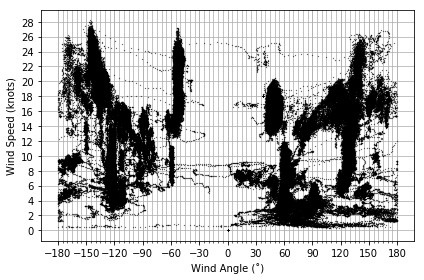

<Figure size 432x288 with 0 Axes>

In [6]:
# Create the bins. Default size: 5˚ by 2 knots.
bins, dx, dy, _, max_y = create_bins(df, [x[1] for x in wind_features], boat_speed_feature[1], exclude=identifier_features + wind_features)

# Plot the bins.
plot_wind_angle_speed(df, [x[1] for x in wind_features], bins_axis_names, -180, 0, 180+1, max_y+1, dx, dy, 0.25, main=True)

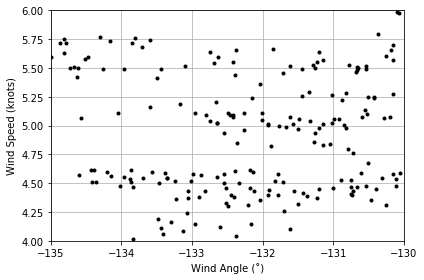

<Figure size 432x288 with 0 Axes>

In [7]:
# Retrieve an example of a bin. (-135 to -130˚, 4 to 6 knots)
bin_name = 'bin_x-135to-130_y4to6'
binned_df, bin_corr = bins[bin_name]['bin'], bins[bin_name]['corr']
x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(bin_dimensions_regex, bin_name)]
dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0

# Plot the bin.
plot_wind_angle_speed(binned_df, [x[1] for x in wind_features], bins_axis_names, x_start, y_start, x_finish, y_finish, dx, dy, 3)

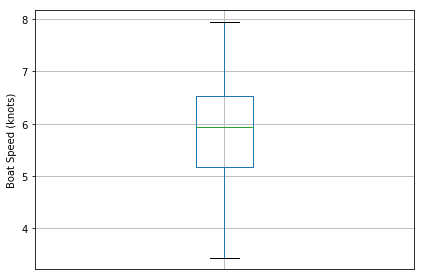

<Figure size 432x288 with 0 Axes>

In [8]:
# Plot the boat speed boxplot.
plot_boxplot(binned_df, boat_speed_feature[1], boxplot_axis_name)

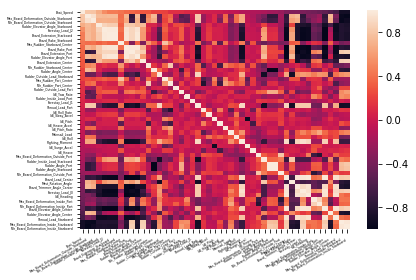

<Figure size 432x288 with 0 Axes>

In [9]:
# Plot the correlation heatmap with boat speed.
plot_corr(binned_df, bin_corr)

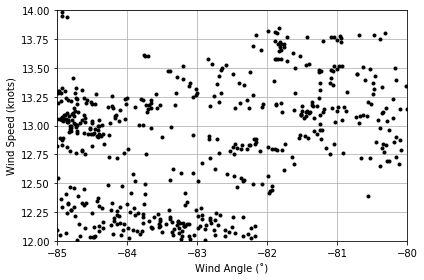

<Figure size 432x288 with 0 Axes>

In [10]:
# Retrieve another example of a bin. (-85 to -80˚, 12 to 14 knots)
bin_name = 'bin_x-85to-80_y12to14'
binned_df, bin_corr = bins[bin_name]['bin'], bins[bin_name]['corr']
x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(bin_dimensions_regex, bin_name)]
dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0

# Plot the bin.
plot_wind_angle_speed(binned_df, [x[1] for x in wind_features], bins_axis_names, x_start, y_start, x_finish, y_finish, dx, dy, 3)

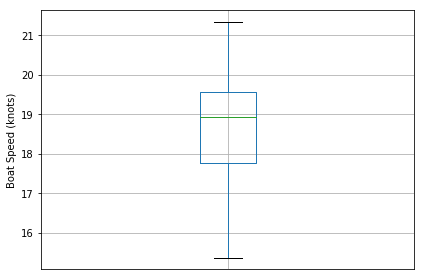

<Figure size 432x288 with 0 Axes>

In [11]:
# Plot the boat speed boxplot.
plot_boxplot(binned_df, boat_speed_feature[1], boxplot_axis_name)

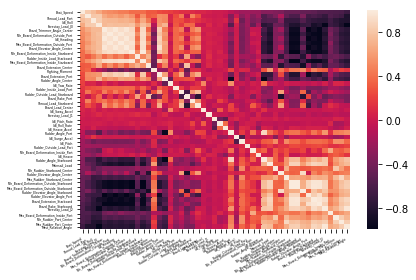

<Figure size 432x288 with 0 Axes>

In [12]:
# Plot the correlation heatmap with boat speed.
plot_corr(binned_df, bin_corr)

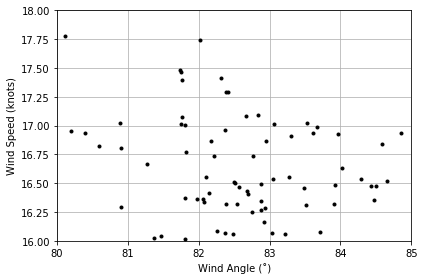

<Figure size 432x288 with 0 Axes>

In [13]:
# Retrieve another example of a bin. (80 to 85˚, 16 to 18 knots)
bin_name = 'bin_x80to85_y16to18'
binned_df, bin_corr = bins[bin_name]['bin'], bins[bin_name]['corr']
x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(bin_dimensions_regex, bin_name)]
dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0

# Plot the bin.
plot_wind_angle_speed(binned_df, [x[1] for x in wind_features], bins_axis_names, x_start, y_start, x_finish, y_finish, dx, dy, 3)

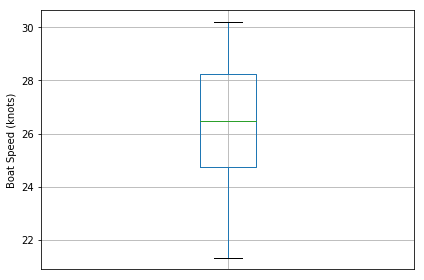

<Figure size 432x288 with 0 Axes>

In [14]:
# Plot the boat speed boxplot.
plot_boxplot(binned_df, boat_speed_feature[1], boxplot_axis_name)

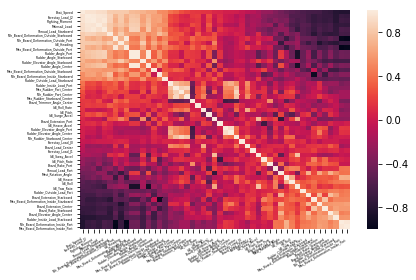

<Figure size 432x288 with 0 Axes>

In [15]:
# Plot the correlation heatmap with boat speed.
plot_corr(binned_df, bin_corr)

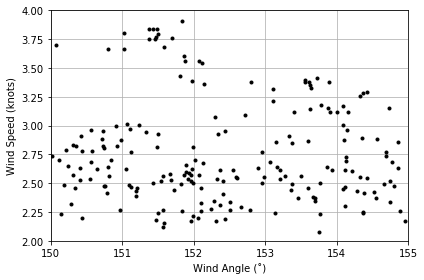

<Figure size 432x288 with 0 Axes>

In [16]:
# Retrieve another example of a bin. (150 to 155˚, 2 to 4 knots)
bin_name = 'bin_x150to155_y2to4'
binned_df, bin_corr = bins[bin_name]['bin'], bins[bin_name]['corr']
x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(bin_dimensions_regex, bin_name)]
dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0

# Plot the bin.
plot_wind_angle_speed(binned_df, [x[1] for x in wind_features], bins_axis_names, x_start, y_start, x_finish, y_finish, dx, dy, 3)

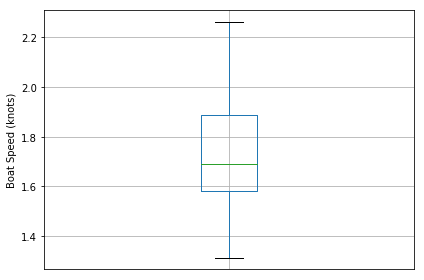

<Figure size 432x288 with 0 Axes>

In [17]:
# Plot the boat speed boxplot.
plot_boxplot(binned_df, boat_speed_feature[1], boxplot_axis_name)

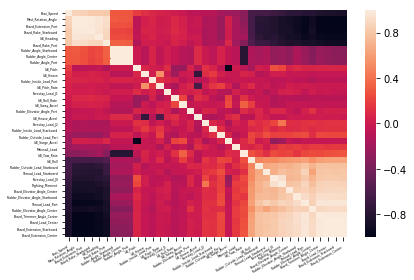

<Figure size 432x288 with 0 Axes>

In [18]:
# Plot the correlation heatmap with boat speed.
plot_corr(binned_df, bin_corr)